# 0.0. IMPORTS

In [56]:
import pandas as pd
import numpy  as np

import seaborn as sns
import xgboost as xgb

from matplotlib            import pyplot as plt
from IPython.core.display  import HTML

from sklearn.metrics       import mean_absolute_error, mean_squared_error
from sklearn.ensemble      import RandomForestRegressor
from sklearn.linear_model  import LinearRegression, Lasso

warnings.filterwarnings( 'ignore' )

## 0.1. Helper Functions

In [2]:
def mean_absolute_percentage_error( y, yhat ):
    return np.mean( np.abs( ( y - yhat ) / y ) )



def ml_error( model_name, y, yhat ):
    mae = mean_absolute_error( y, yhat )
    mape = mean_absolute_percentage_error( y, yhat )
    rmse = np.sqrt( mean_squared_error( y, yhat ) )
    
    return pd.DataFrame( { 'Model Name': model_name, 
                           'MAE': mae, 
                           'MAPE': mape,
                           'RMSE': rmse }, index=[0] ) 
    
    
def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()

In [3]:
jupyter_settings()

Populating the interactive namespace from numpy and matplotlib


## 0.2. Loading Dataset

In [4]:
df_raw = pd.read_csv( '../data/data_labs.csv' )

# 1.0. DESCRICAO DOS DADOS

In [5]:
df1 = df_raw.copy()

## 1.1. Data Dimensions

In [6]:
print( 'Number of Rows: {}'.format( df1.shape[0] ) )
print( 'Number of Cols: {}'.format( df1.shape[1] ) )

Number of Rows: 179149
Number of Cols: 14


## 1.2. Data Types

In [7]:
df1.dtypes

order_id             object
code                 object
quantity              int64
price               float64
pis_cofins          float64
icms                float64
tax_substitution    float64
category             object
liquid_cost         float64
order_status         object
capture_date         object
process_date         object
process_status       object
source_channel       object
dtype: object

## 1.3. Check NA

In [8]:
df1.isna().sum()

order_id            0
code                0
quantity            0
price               0
pis_cofins          0
icms                0
tax_substitution    0
category            0
liquid_cost         0
order_status        0
capture_date        0
process_date        0
process_status      0
source_channel      0
dtype: int64

## 1.4. Change Data Types

In [9]:
# Date format
df1['capture_date'] = pd.to_datetime( df1['capture_date'] )

df1.loc[df1['process_date'] == '0000-00-00', 'process_date'] = '1900-01-01'
df1['process_date'] = pd.to_datetime( df1['process_date'] )

## 1.5. Descriptive Statistics

### 1.5.1. Numerical

In [10]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )
cat_attributes = df1.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )
time_attributes = df1.select_dtypes( include=['datetime64[ns]'] )

In [11]:
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,quantity,1.0000,100.0000,99.0000,1.055278,1.0000,0.597940,60.085256,6821.090621
1,price,1.0300,19993.0000,19991.9700,234.638585,194.4000,186.638398,27.109077,2125.723778
2,pis_cofins,0.0000,1849.3525,1849.3525,19.525329,17.5195,17.402772,22.766807,1777.300240
3,icms,0.0000,3598.7400,3598.7400,25.095547,21.4920,32.333136,14.203649,1096.176530
4,tax_substitution,0.0000,280.8342,280.8342,17.872443,0.0000,28.125583,2.211765,8.212045
5,liquid_cost,4.1141,896.6814,892.5673,136.034906,117.0820,83.603010,2.066601,8.568905


### 1.5.2. Categorical

In [12]:
cat_attributes = cat_attributes.drop( ['order_id'], axis=1 )

In [13]:
cat_attributes.apply( lambda x: x.unique().shape[0] )

code              131
category           11
order_status       17
process_status      2
source_channel     16
dtype: int64

### 1.5.3. Temporal

# 2.0. FEATURE ENGINEERING

In [14]:
df2 = df1.copy()

## 2.1. Feature Engineering

In [15]:
# year
df2['capture_date_year'] = df2['capture_date'].dt.year
df2['process_date_year'] = df2['process_date'].dt.year

# month
df2['capture_date_month'] = df2['capture_date'].dt.month
df2['process_date_month'] = df2['process_date'].dt.month

# day
df2['capture_date_day'] = df2['capture_date'].dt.day
df2['process_date_day'] = df2['process_date'].dt.day

# week of year
df2['capture_date_week_of_year'] = df2['capture_date'].dt.weekofyear
df2['process_date_week_of_year'] = df2['process_date'].dt.weekofyear

# year week
df2['capture_year_week'] = df2['capture_date'].dt.strftime( '%Y-%W' )
df2['process_year_week'] = df2['process_date'].dt.strftime( '%Y-%W' )

# unit price
df2['unit_price'] = df2['price'] / df2['quantity']

# Category
old_category = list( df2['category'].drop_duplicates() )
new_category = [ 'C01', 'C02', 'C03', 'C04', 'C05', 'C06', 'C07', 'C08', 'C09', 'C10', 'C11' ]
category_de_para = dict( zip( old_category, new_category ) ) 
df2['category'] = df2['category'].map( category_de_para )

# Produts ( code )
old_products = list( df2['code'].drop_duplicates() )
new_products = ['P' + str( i ) for i in np.arange( 1, 132 )]
code_de_para = dict( zip( old_products, new_products ) )
df2['code'] = df2['code'].map( code_de_para )

# Source Channel
old_channel = list( df2['source_channel'].drop_duplicates() )
new_channel = ['channel' + str( i ) for i in np.arange( 1, 17 ) ]
channel_de_para = dict( zip( old_channel, new_channel ) )
df2['source_channel'] = df2['source_channel'].map( channel_de_para )

# Order Id
old_order = list( df2['order_id'].drop_duplicates() )
new_order = [i for i in np.arange( 1, 175576 )]
order_de_para = dict( zip( old_order, new_order ) )
df2['order_id'] = df2['order_id'].map( order_de_para )

# 3.0. FILTRAGEM DE VARIÁVEIS

In [16]:
df3 = df2.copy()

## 3.1. Seleção das Linhas

## 3.2. Seleção das Colunas

In [17]:
drop_cols = [
    'order_id',
    'price', 
    'pis_cofins', 'icms', 'tax_substitution', 'liquid_cost', 
    'order_status', 'process_status',
    'process_date', 'process_date_year', 'process_date_month', 'process_date_day', 'process_date_week_of_year', 
    'source_channel']

df3 = df3.drop( drop_cols, axis=1 )

# 4.0. ANÁLISE EXPLORATÓRIA DE DADOS

In [18]:
df4 = df3.copy()

## 4.1. Analise Univariada

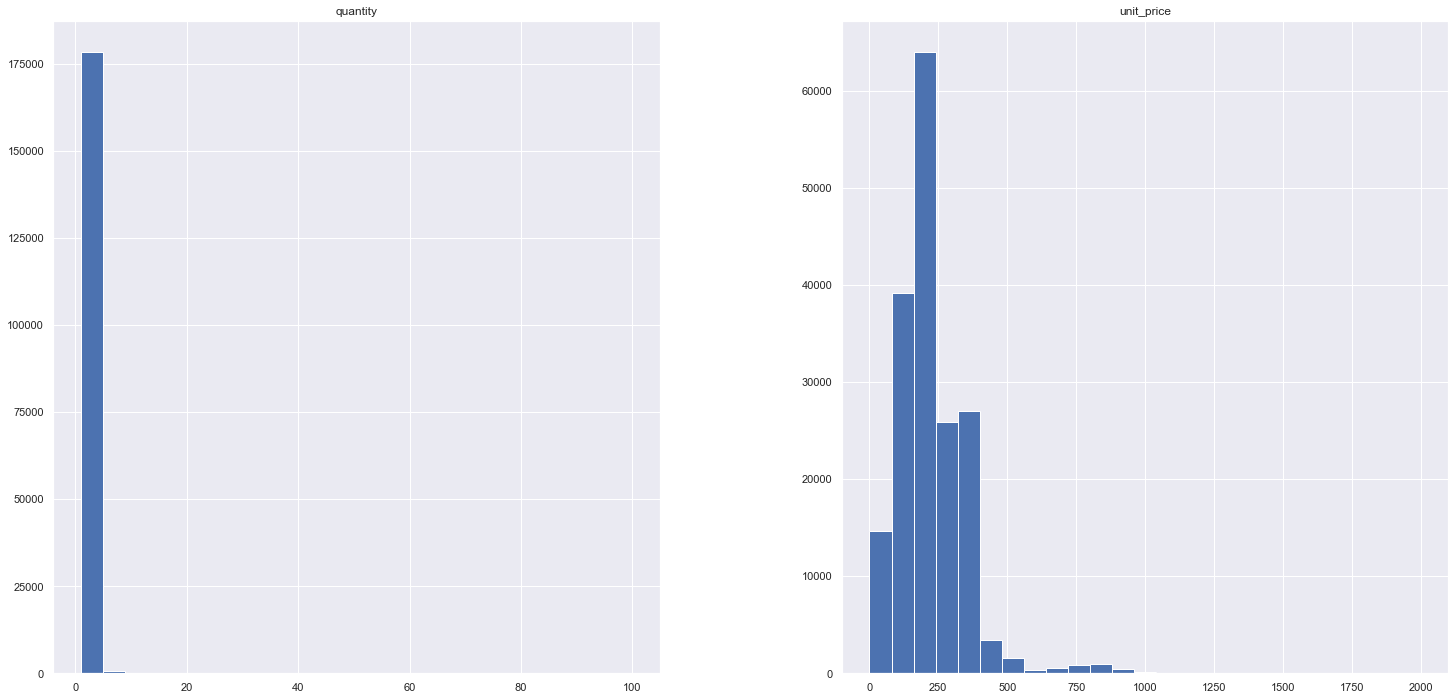

In [19]:
df4[['quantity', 'unit_price']].hist( bins=25 );

## 4.2. Analise Bivariada

In [20]:
aux = df4[['code', 'quantity', 'capture_date']].groupby( ['code', 'capture_date'] ).sum().reset_index()
aux = aux[aux['capture_date'] != '1900-01-01']

In [21]:
aux.head()

,code,capture_date,quantity
0,P1,2016-06-11,2
1,P1,2016-06-12,1
2,P1,2016-06-13,3
3,P1,2016-06-14,1
4,P1,2016-09-18,2


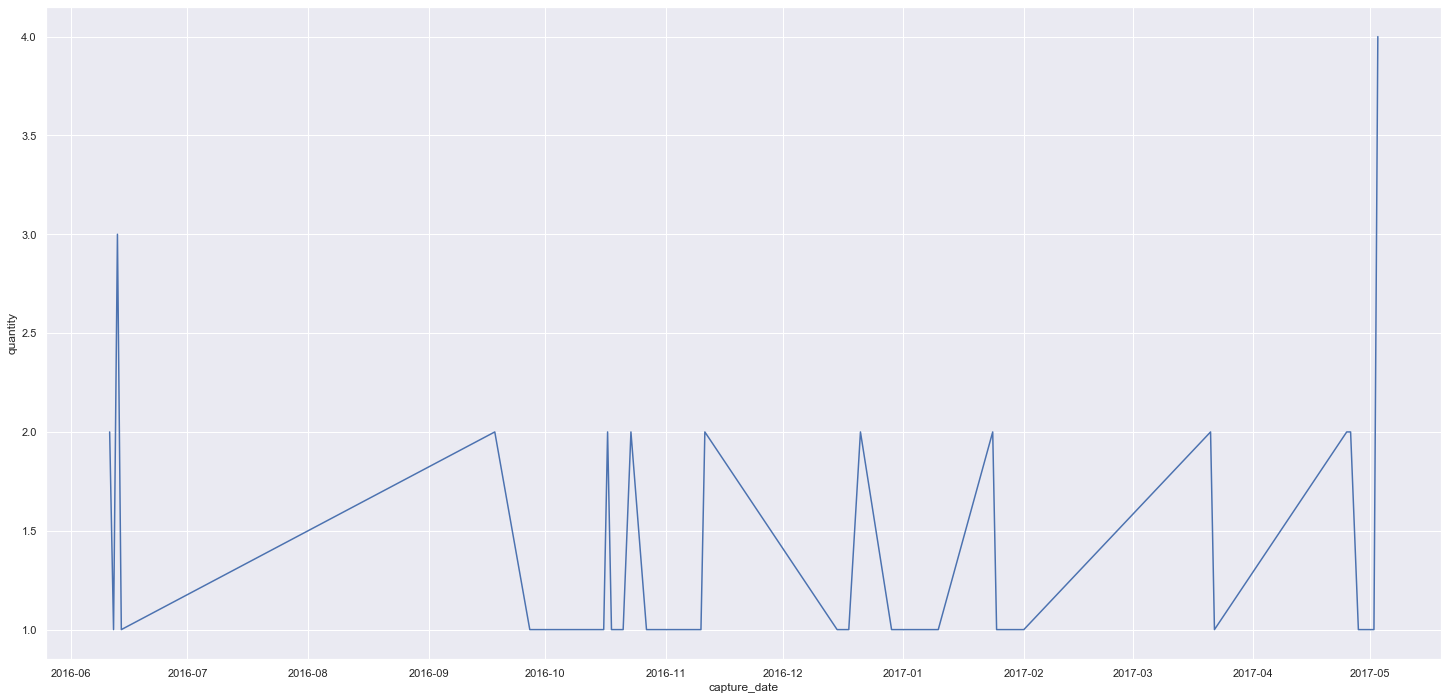

In [22]:
 sns.lineplot( x='capture_date', y='quantity', data=aux[aux['code'] == 'P1'] ) 

## 4.3. Analise Multivariada

# 5.0. DATA PREPARATION

In [23]:
df5 = df4.copy()

## 5.1. Normalização

## 5.2. Rescaling

## 5.4. Encoding

In [24]:
df5 = pd.get_dummies( df5, columns=['category'] )

## 5.5. Transformação

# 6.0. FEATURE SELECTION

In [25]:
df6 = df5.copy()

## 6.1. Split dataframe into training and test dataset

In [26]:
df6.head()

,code,quantity,capture_date,capture_date_year,capture_date_month,capture_date_day,capture_date_week_of_year,capture_year_week,process_year_week,unit_price,category_C01,category_C02,category_C03,category_C04,category_C05,category_C06,category_C07,category_C08,category_C09,category_C10,category_C11
0,P1,1,2016-06-11,2016,6,11,23,2016-23,2016-23,978.90,1,0,0,0,0,0,0,0,0,0,0
1,P1,1,2016-06-11,2016,6,11,23,2016-23,2016-23,1036.29,1,0,0,0,0,0,0,0,0,0,0
2,P1,1,2016-06-12,2016,6,12,23,2016-23,2016-23,978.90,1,0,0,0,0,0,0,0,0,0,0
3,P1,1,2016-06-13,2016,6,13,24,2016-24,1900-01,978.90,1,0,0,0,0,0,0,0,0,0,0
4,P1,1,2016-06-13,2016,6,13,24,2016-24,2016-24,976.05,1,0,0,0,0,0,0,0,0,0,0


In [34]:
# training dataset
X_train = df6[df6['capture_date'] < '2017-03-01']
y_train = X_train['quantity']

# test dataset
X_test = df6[df6['capture_date'] >= '2017-03-01']
y_test = X_test['quantity']

print( 'Training Min Date: {}'.format( X_train['capture_date'].min() ) )
print( 'Training Max Date: {}'.format( X_train['capture_date'].max() ) )

print( '\nTest Min Date: {}'.format( X_test['capture_date'].min() ) )
print( 'Test Max Date: {}'.format( X_test['capture_date'].max() ) )

Training Min Date: 2016-06-01 00:00:00
Training Max Date: 2017-02-28 00:00:00

Test Min Date: 2017-03-01 00:00:00
Test Max Date: 2017-06-01 00:00:00


## 6.3. Manual Feature Selection

In [63]:
cols_selected_boruta = [
    'capture_date_year',
    'capture_date_month',
    'capture_date_day',
    'capture_date_week_of_year',
    'unit_price',
    'category_C01',
    'category_C02',
    'category_C03',
    'category_C04',
    'category_C05',
    'category_C06',
    'category_C07',
    'category_C08',
    'category_C09',
    'category_C10',
    'category_C11',
]


# columns to add
feat_to_add = ['capture_date', 'quantity']

cols_selected_boruta_full = cols_selected_boruta.copy()
cols_selected_boruta_full.extend( feat_to_add )

# 7.0. MACHINE LEARNING MODELLING

In [62]:
x_train = X_train[ cols_selected_boruta ]
x_test = X_test[ cols_selected_boruta ]

## 7.1. Average Model

In [47]:
aux1 = X_test.copy()
aux1['quantity'] = y_test.copy()

# prediction
aux2 = aux1[['code', 'quantity']].groupby( 'code' ).mean().reset_index().rename( columns={'quantity': 'predictions'} )
aux1 = pd.merge( aux1, aux2, how='left', on='code' )
yhat_baseline = aux1['predictions']

# performance
baseline_result = ml_error( 'Average Model', y_test, yhat_baseline ) 
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,0.087534,0.062196,0.550058


## 7.2. Linear Regression Model

In [48]:
x_train.head()

,capture_date_year,capture_date_month,capture_date_day,capture_date_week_of_year,unit_price,category_C01,category_C02,category_C03,category_C04,category_C05,category_C06,category_C07,category_C08,category_C09,category_C10,category_C11
0,2016,6,11,23,978.90,1,0,0,0,0,0,0,0,0,0,0
1,2016,6,11,23,1036.29,1,0,0,0,0,0,0,0,0,0,0
2,2016,6,12,23,978.90,1,0,0,0,0,0,0,0,0,0,0
3,2016,6,13,24,978.90,1,0,0,0,0,0,0,0,0,0,0
4,2016,6,13,24,976.05,1,0,0,0,0,0,0,0,0,0,0


In [52]:
# model
lr = LinearRegression().fit( x_train, y_train )

# prediction
yhat_lr = lr.predict( x_test )

# performance
lr_result = ml_error( 'Linear Regression', y_test, yhat_lr )
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,0.099321,0.069399,0.552179


## 7.3. Linear Regression Model - Lasso

In [53]:
# model
lrr = Lasso( alpha=0.01 ).fit( x_train, y_train )

# prediction
yhat_lrr = lrr.predict( x_test )

# performance
lrr_result = ml_error( 'Linear Regression - Lasso', y_test, yhat_lrr )
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression - Lasso,0.105474,0.075485,0.553042


## 7.4. Random Forest Regressor

In [54]:
# model
rf = RandomForestRegressor( n_estimators=100, n_jobs=-1, random_state=42 ).fit( x_train, y_train )

# prediction
yhat_rf = rf.predict( x_test )

# performance
rf_result = ml_error( 'Random Forest Regressor', y_test, yhat_rf )
rf_result

,Model Name,MAE,MAPE,RMSE
0,Random Forest Regressor,0.227794,0.197258,1.152769


## 7.5. XGBoost Regressor

In [57]:
# model
model_xgb = xgb.XGBRegressor( objective='reg:squarederror',
                              n_estimators=100, 
                              eta=0.01, 
                              max_depth=10, 
                              subsample=0.7,
                              colsample_bytee=0.9 ).fit( x_train, y_train )

# prediction
yhat_xgb = model_xgb.predict( x_test )

# performance
xgb_result = ml_error( 'XGBoost Regressor', y_test, yhat_xgb )
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,0.231864,0.19969,1.333192


## 7.6. Compare Model Performance

### 7.6.1. Single Performance

In [58]:
modelling_result = pd.concat( [baseline_result, lr_result, lrr_result, rf_result, xgb_result] )
modelling_result.sort_values( 'RMSE' )

,Model Name,MAE,MAPE,RMSE
0,Average Model,0.087534,0.062196,0.550058
0,Linear Regression,0.099321,0.069399,0.552179
0,Linear Regression - Lasso,0.105474,0.075485,0.553042
0,Random Forest Regressor,0.227794,0.197258,1.152769
0,XGBoost Regressor,0.231864,0.199690,1.333192


# 8.0 HYPERPARAMETER FINE TUNING

## 8.1. Random Search

## 8.2. Final Model

# 9.0. TRADUCAO E INTERPRETACAO DO ERRO 

In [66]:
df9.head()

,capture_date_year,capture_date_month,capture_date_day,capture_date_week_of_year,unit_price,category_C01,category_C02,category_C03,category_C04,category_C05,category_C06,category_C07,category_C08,category_C09,category_C10,category_C11,capture_date,quantity
43,2017,3,21,12,978.93,1,0,0,0,0,0,0,0,0,0,0,2017-03-21,1
44,2017,3,21,12,970.00,1,0,0,0,0,0,0,0,0,0,0,2017-03-21,1
45,2017,3,22,12,980.82,1,0,0,0,0,0,0,0,0,0,0,2017-03-22,1
46,2017,4,25,17,854.10,1,0,0,0,0,0,0,0,0,0,0,2017-04-25,1
47,2017,4,25,17,949.00,1,0,0,0,0,0,0,0,0,0,0,2017-04-25,1


In [78]:
df9 = X_test[ cols_selected_boruta_full ]

# rescale
df9['predictions'] = yhat_xgb

## 9.1. Business Performance

## 9.2. Machine Learning Performance

In [79]:
df9['error'] = df9['quantity'] - df9['predictions']
df9['error_rate'] = df9['predictions'] / df9['quantity']

In [80]:
df9.head()

,capture_date_year,capture_date_month,capture_date_day,capture_date_week_of_year,unit_price,category_C01,category_C02,category_C03,category_C04,category_C05,category_C06,category_C07,category_C08,category_C09,category_C10,category_C11,capture_date,quantity,predictions,error,error_rate
43,2017,3,21,12,978.93,1,0,0,0,0,0,0,0,0,0,0,2017-03-21,1,1.016020,-0.016020,1.016020
44,2017,3,21,12,970.00,1,0,0,0,0,0,0,0,0,0,0,2017-03-21,1,1.016020,-0.016020,1.016020
45,2017,3,22,12,980.82,1,0,0,0,0,0,0,0,0,0,0,2017-03-22,1,1.082009,-0.082009,1.082009
46,2017,4,25,17,854.10,1,0,0,0,0,0,0,0,0,0,0,2017-04-25,1,1.032731,-0.032731,1.032731
47,2017,4,25,17,949.00,1,0,0,0,0,0,0,0,0,0,0,2017-04-25,1,1.009406,-0.009406,1.009406


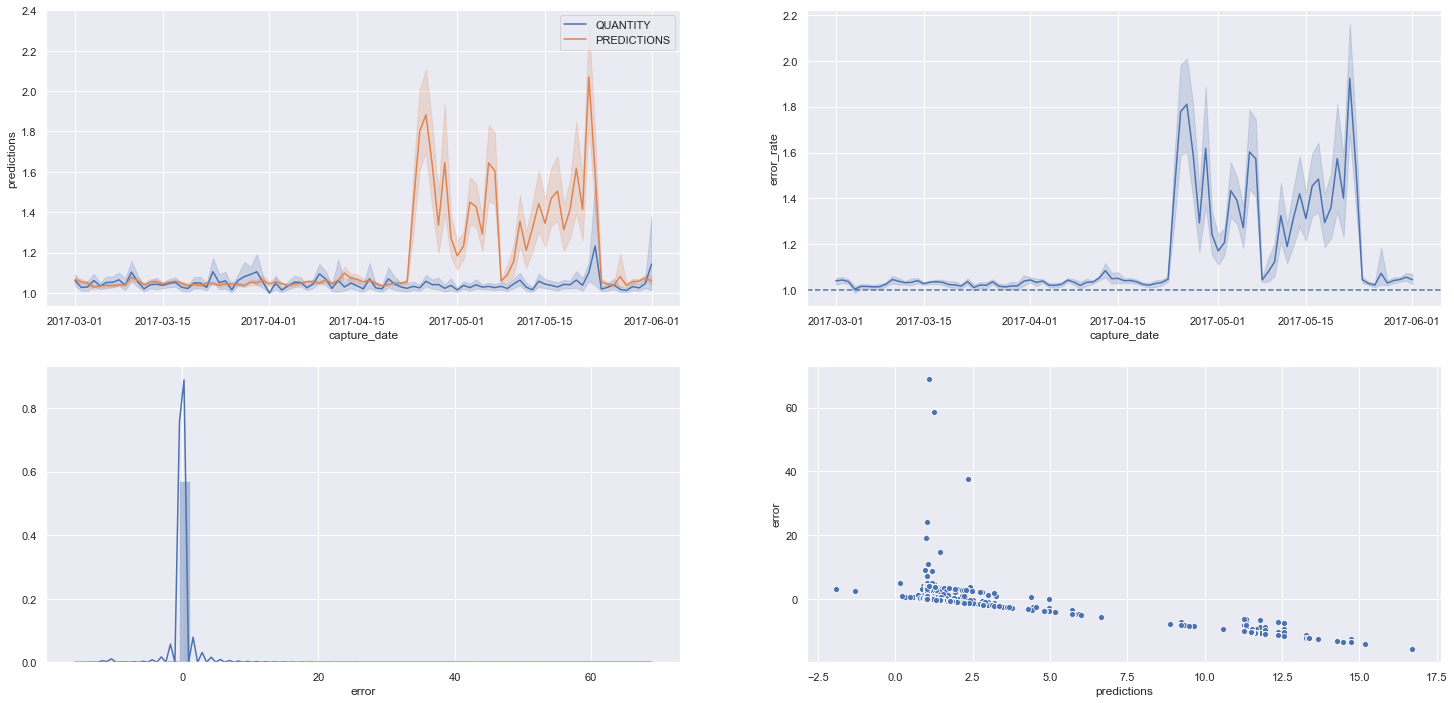

In [81]:
plt.subplot( 2, 2, 1 )
sns.lineplot( x='capture_date', y='quantity', data=df9, label='QUANTITY' )
sns.lineplot( x='capture_date', y='predictions', data=df9, label='PREDICTIONS' )

plt.subplot( 2, 2, 2 )
sns.lineplot( x='capture_date', y='error_rate', data=df9 )
plt.axhline( 1, linestyle='--')

plt.subplot( 2, 2, 3 )
sns.distplot( df9['error'] )

plt.subplot( 2, 2, 4 )
sns.scatterplot( df9['predictions'], df9['error'] )